In [8]:
import os
import numpy as np
import trimesh
import configparser
import argparse
from objectron.dataset import iou
from objectron.dataset import box
from objectron.dataset.graphics import draw_annotation_on_image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


aux_path = '17_video-aux-00000.txt'
pred_path = '17_video-cam-00000.txt'
obj_path = '17_video-mesh-00000.obj'

# aux = None
# if (os.path.exists(aux_path)):
#     with open(aux_path) as f:
#         aux = f.read().split()
# for i in range(len(aux)):
#     aux[i] = eval(aux[i])
# foc = aux[:2]
# center = aux[2:4]
# ppoint = aux[4:6]
# cams = aux[6:]

pred = None
if (os.path.exists(pred_path)):
    with open(pred_path) as f:
        pred = f.read().split()
for i in range(len(pred)):
    pred[i] = eval(pred[i])
pred = np.array(pred).reshape(4, 4)
print(pred)

fx, fy = pred[3, 0], pred[3, 1]
px, py = pred[3, 2], pred[3, 3]

transformation = pred.copy()
transformation[3, :3] = 0
transformation[3, 3] = 1
print(transformation)


obj_path = 'chair-0-simp-manifold.obj'
obj = None
if (os.path.exists(obj_path)):
    obj = trimesh.load_mesh(obj_path)
print(obj.vertices) # (n, 3)

minx, maxx, miny, maxy, minz, maxz = obj.vertices[:,0].min(), obj.vertices[:,0].max(), \
    obj.vertices[:,1].min(), obj.vertices[:,1].max(), obj.vertices[:,2].min(), obj.vertices[:,2].max()
scale = np.array([maxx - minx, maxy - miny, maxz - minz])

bbox = np.array([
    [(minx+maxx)/2, (miny+maxy)/2, (minz+maxz)/2],
    [minx, miny, minz], 
    [minx, miny, maxz],
    [minx, maxy, minz],
    [minx, maxy, maxz],
    [maxx, miny, minz],
    [maxx, miny, maxz],
    [maxx, maxy, minz],
    [maxx, maxy, maxz]
])
# adjacent_list = [[], [2, 3, 4, 5], [3, 4, 6], [4, 7], [8], [6, 7], [8], [8], []]
# print(maxx-minx, maxy-miny, maxz-minz)


rotation = transformation[:3, :3].T
translation = transformation[:3, 3]
# bbox = bbox @ rotation + translation
bbox = box.Box(bbox)
# obj.vertices = obj.vertices @ rotation + translation
print(obj.vertices)

[[ 8.11336875e-01 -3.93124819e-01  4.32649225e-01 -6.54630885e-02]
 [ 4.21226799e-01  9.06332076e-01  3.36179994e-02 -8.62547159e-02]
 [-4.05339926e-01  1.54967904e-01  9.00935352e-01  2.78985157e+01]
 [ 7.12648438e+03  7.12648438e+03  7.01000000e+02  7.61000000e+02]]
[[ 0.81133687 -0.39312482  0.43264922 -0.06546309]
 [ 0.4212268   0.90633208  0.033618   -0.08625472]
 [-0.40533993  0.1549679   0.90093535 27.8985157 ]
 [ 0.          0.          0.          1.        ]]
[[ 733.184  139.066 2476.16 ]
 [ 278.528  284.4   2439.43 ]
 [ 729.088  549.146 2437.89 ]
 ...
 [ 342.035  941.404 2017.13 ]
 [ 393.235  966.834 2018.36 ]
 [ 731.387  289.406 1966.56 ]]
[[ 733.184  139.066 2476.16 ]
 [ 278.528  284.4   2439.43 ]
 [ 729.088  549.146 2437.89 ]
 ...
 [ 342.035  941.404 2017.13 ]
 [ 393.235  966.834 2018.36 ]
 [ 731.387  289.406 1966.56 ]]


In [9]:
bbox2 = box.Box.from_transformation(transformation[:3, :3], transformation[:3, 3], scale)
print(bbox2.vertices)

[[-6.54630885e-02 -8.62547159e-02  2.78985157e+01]
 [-1.36320386e+02 -6.24110076e+02 -2.12924516e+02]
 [ 1.20582397e+02 -6.04148045e+02  3.22041886e+02]
 [-5.68228894e+02  3.71636099e+02 -4.26682690e+01]
 [-3.11326111e+02  3.91598131e+02  4.92298134e+02]
 [ 3.11195185e+02 -3.91770641e+02 -4.36501102e+02]
 [ 5.68097968e+02 -3.71808609e+02  9.84653004e+01]
 [-1.20713324e+02  6.03975535e+02 -2.66244855e+02]
 [ 1.36189460e+02  6.23937567e+02  2.68721548e+02]]


In [10]:
def draw_boxes(boxes = [], clips = [], colors = ['r', 'b', 'g', 'k'], perspective = []):
  """Draw a list of boxes.

      The boxes are defined as a list of vertices
  """
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')
  for i, b in enumerate(boxes):
    x, y, z = b[:, 0], b[:, 1], b[:, 2]
    ax.scatter(x, y, z, c = 'r')
    for j, e in enumerate(box.EDGES):
      ax.plot(x[e], y[e], z[e], linewidth=2, c=colors[i % len(colors) + j // 4])

  if (len(clips)):
    points = np.array(clips)
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=10, c='k', alpha=0.1)
    
  plt.gca().patch.set_facecolor('white')
  ax.w_xaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
  ax.w_yaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))
  ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))

  # rotate the axes and update
  ax.view_init(perspective[0], perspective[1])
  plt.draw()
  plt.show()

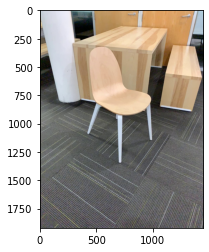

In [6]:
img = cv2.imread('17_video-00000.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_annotation_on_image(img, bbox.vertices, np.array([9]))
plt.imshow(img)

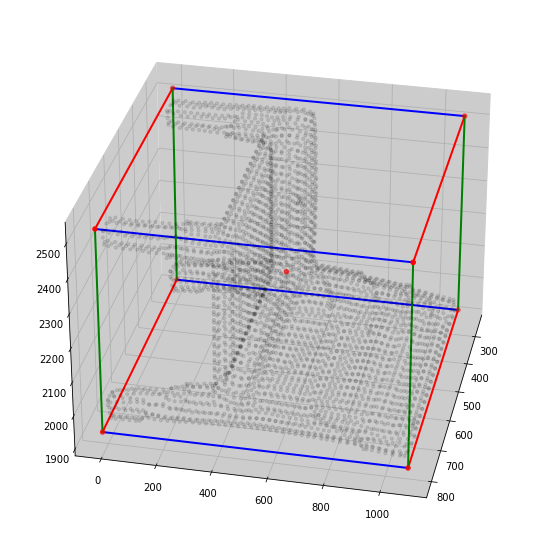

In [11]:
# (elevation, azimuth) in degrees
# perspective = [360 * np.random.random(), 360 * np.random.random()]
# perspective = [0, 0]
# perspective = [-90, -90]
perspective = [30, 12]
draw_boxes([bbox.vertices], clips=obj.vertices, perspective=perspective)